<a href="https://colab.research.google.com/github/Dharani578/FMML_COURSE/blob/main/FMML_Module_9_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 3**
### Module coordinator: Kushagra Agarwal

## 1. Understanding Convolutions

<img src="https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc" width=650px/>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Central to CNNs, a convolution operation is a linear element-wise multiplication operation between a small filter/kernel and same-sized patch from the image. We move this filter over the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image.

Let's look at the convolution formula:

Convolution between image
$f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>

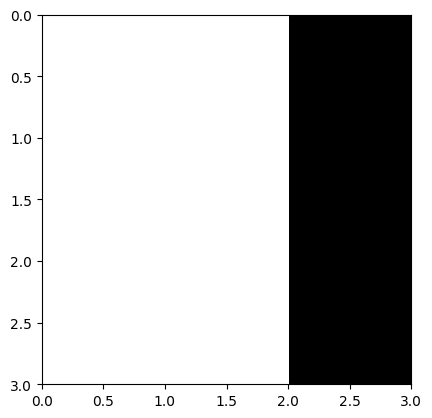

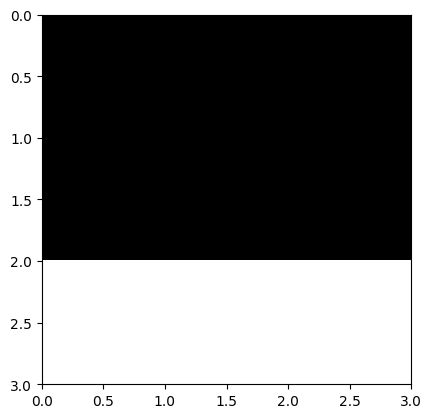

In [3]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [4]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [5]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Similarly, horizontal edge is detected in second.

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [6]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

## Pooling Layers

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

1) Max Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png' height=150px/>

2) Average Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png' height=150px/>

## Softmax layer/activation
Recall that logistic regression produces a decimal between 0 and 1.0. For example, a logistic regression output of 0.8 from an email classifier suggests an 80% chance of an email being spam and a 20% chance of it being not spam. Clearly, the sum of the probabilities of an email being either spam or not spam is 1.0.

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.
Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer.

<img src='https://miro.medium.com/max/1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg' height=170px />

## Learning to train a CNN network

In [12]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 101231953.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [15]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [16]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [17]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [19]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [20]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [21]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/5, Loss: 0.0130, Accuracy: 39.3700
Epoch 2/5, Loss: 0.0096, Accuracy: 56.3540
Epoch 3/5, Loss: 0.0080, Accuracy: 63.6780
Epoch 4/5, Loss: 0.0070, Accuracy: 68.5380
Epoch 5/5, Loss: 0.0060, Accuracy: 72.8540


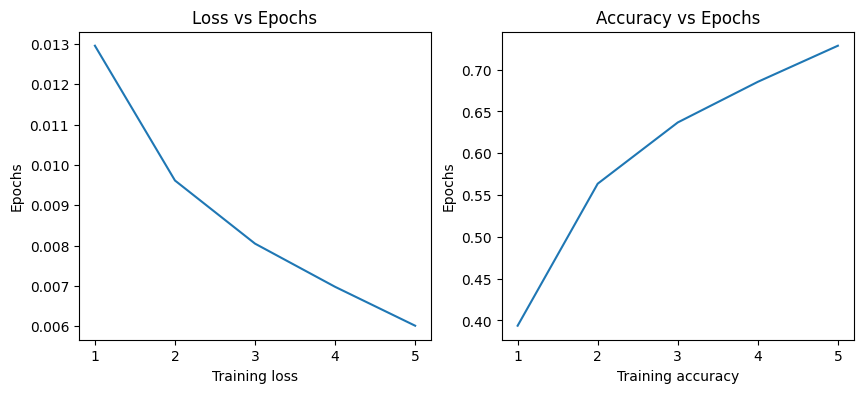

In [22]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [23]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 65 %


## Questions
1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?


1 ANS

Spatial Hierarchical Feature Learning: CNNs are designed to automatically learn hierarchical representations of features directly from raw pixel values. They utilize convolutional layers, which capture local patterns and spatial dependencies in the input image. This spatial hierarchical feature learning makes CNNs particularly effective for image-related tasks.
Translation Invariance: CNNs leverage shared weights and local connectivity through convolutional layers, allowing them to achieve translation invariance. This means that the learned features can detect patterns regardless of their location in the image, making CNNs robust to translations, rotations, and other transformations.
Parameter Efficiency: CNNs typically have fewer parameters compared to fully connected ANNs when applied to image data. The use of convolutional and pooling layers reduces the number of parameters by enforcing weight sharing and spatial subsampling. This parameter efficiency makes CNNs more scalable and computationally tractable, especially for large-scale image datasets.
Feature Reusability: CNN architectures often consist of multiple layers with shared weights. This enables feature reusability across different regions of the image and different parts of the network. As a result, CNNs can learn a compact and efficient representation of image features, leading to better generalization and improved performance on unseen data.
Local Connectivity and Weight Sharing: CNNs exploit the local connectivity and weight sharing schemes present in convolutional layers. By connecting each neuron to only a local region of the input and sharing weights across different spatial locations, CNNs can efficiently capture spatial structures and patterns present in images, leading to improved performance in image classification tasks.
Pre-Trained Models and Transfer Learning: CNNs can benefit from transfer learning, where pre-trained models on large-scale datasets (e.g., ImageNet) are fine-tuned for specific image classification tasks. This approach allows leveraging the knowledge gained from training on large datasets, even with limited labeled data for the target task, leading to faster convergence and improved performance.
Overall, these advantages make CNNs well-suited for image classification tasks, offering superior performance, efficiency, and generalization compared to traditional fully connected ANNs.







2 ANS





In [24]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define CNN model architecture
def create_model(optimizer='adam', learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer")

    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

# Load and preprocess dataset (e.g., CIFAR-10)
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Create KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define hyperparameters grid for tuning
param_grid = {'optimizer': ['adam', 'sgd', 'rmsprop'],
              'learning_rate': [0.001, 0.01, 0.1]}

# Perform grid search for hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_images, train_labels)

# Report best hyperparameters and test accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
test_accuracy = grid.score(test_images, test_labels)
print("Test Accuracy:", test_accuracy)


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

3 ANS  


Simplification of Model: With fewer convolutional layers, the model becomes simpler and has fewer parameters to learn. This can lead to faster training times and reduced computational complexity.
Reduced Capacity for Feature Extraction: Convolutional layers are responsible for learning hierarchical representations of features in the input data. By reducing the number of convolutional layers to only one, the model's capacity for capturing complex and abstract features from the input images is limited. This may result in decreased performance, especially for tasks where hierarchical feature extraction is crucial, such as image classification or object detection.
Limited Ability to Capture Spatial Hierarchies: Multiple convolutional layers allow the model to capture spatial hierarchies of features in the input images, starting from low-level features (e.g., edges, textures) to high-level features (e.g., object parts, object shapes). With only one convolutional layer, the model may not be able to effectively capture these spatial hierarchies, leading to suboptimal performance, especially on more challenging datasets.
Difficulty in Learning Complex Patterns: Deep CNNs with multiple convolutional layers have the ability to learn increasingly complex patterns and relationships in the data. By reducing the number of convolutional layers, the model's ability to learn intricate patterns and variations in the input images is compromised, potentially limiting its performance on tasks requiring fine-grained classification or detection.
Overall, reducing the number of convolutional layers to only one simplifies the model but may also limit its capacity for feature extraction and ability to learn complex patterns, potentially leading to decreased performance on image-related tasks.







4 ANS

Binary Classification: If the task is binary classification (i.e., there are only two classes), it's common to use a single neuron in the output layer with a sigmoid activation function. The sigmoid activation function squashes the output into the range [0, 1], representing the probability of the positive class. This is simpler and more suitable than using Softmax for binary classification tasks.
Regression: In regression tasks, where the goal is to predict continuous values rather than class probabilities, the output layer typically consists of a single neuron without any activation function or with a linear activation function.
Feature Extraction: In some cases, especially when using a pre-trained CNN for feature extraction in transfer learning, the last layer may be removed or replaced with a custom output layer specific to the task at hand. In such cases, the choice of activation function depends on the specific requirements of the task.
In summary, while Softmax activation is commonly used in the last layer of CNNs for multi-class classification tasks, it may not be appropriate for all types of tasks or network configurations. The choice of activation function in the last layer depends on the nature of the problem being solved and the desired output format.